# **Spatiotemporal demand forecasting with neural networks**

In [1]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from utils import (
    load_data, 
    summarize_data, summary_plots, map_hotspot,
    grid_data, widen_grid_data, make_3d_array,
    plot_timeseries_cells,
    plot_grid, split_data,
    WindowGenerator, compile_and_fit, make_ypred
)
from constants import BATCH_SIZE, MAX_EPOCHS, NROW, NCOL

### **Get data**

The data consists of X-Y-t (longitude, latitude, time) coordinates of demand events. The goal is to create models that can predict the spatiotemporal distribution of these events in the near future.

In [2]:
demand = load_data('data/demand.csv')

In [3]:
demand.head()

,start_lat,start_lng
start_time,,
2022-03-06 15:02:39.329452,59.407910,24.689836
2022-03-10 11:15:55.177526,59.441650,24.762712
2022-03-06 14:23:33.893257,59.435404,24.749795
2022-03-03 09:11:59.104192,59.406920,24.659006
2022-03-06 00:13:01.290346,59.434940,24.753641


### **Explore data**

In [4]:
summarize_data(demand)

Total no. events = 627,210
Time range = 2022-03-01 00:00 - 2022-03-28 23:59


Spatiotemporal distribution of events shows daily activity pattern and strong concentration in a hotspot. Slight increase from Mo. to Sa., and over the weeks of March. Last week is incomplete (!). 

**Not possible to assess/model seasonal pattern (winter-spring-summer-autumn) with just one month, as well as multi-annual trends.**

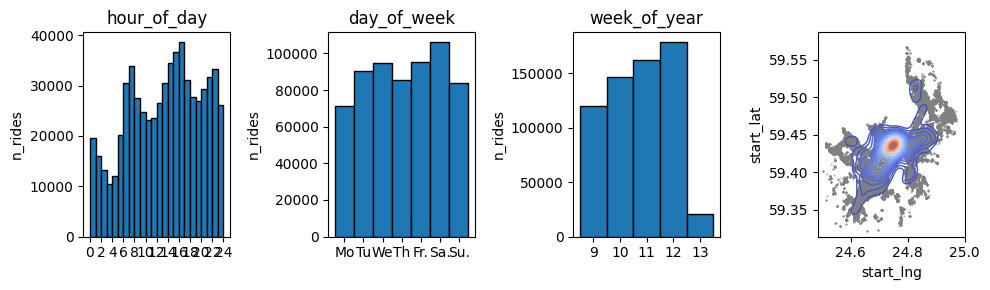

In [5]:
summary_plots(demand)

Zooming in to the downtown hotspot doesn't show any further spatial structure

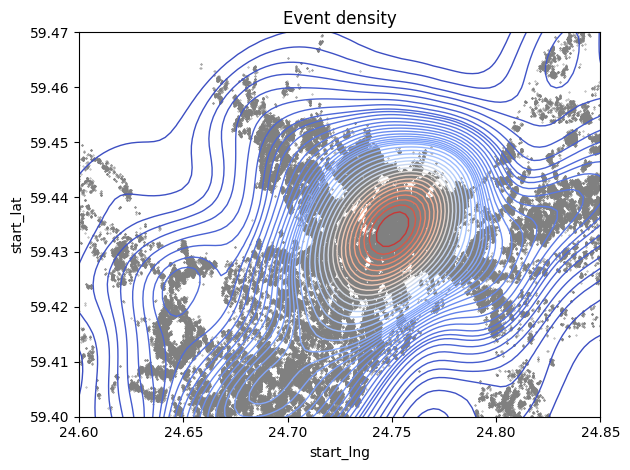

In [6]:
map_hotspot(demand)

### **Feature engineering - `n_events`**

The original continuous dataset can be grouped into temporal and lat-long bins to create a discrete spatiotemporal distribution of event counts -> `n_events`

In [7]:
gridded_data = grid_data(demand, nrow=NROW, ncol=NCOL, tbin='10min')

In [8]:
gridded_data.head(4)

,time_bin,lat_bin,lng_bin,n_events
0,2022-03-01,"(59.322, 59.371]","(24.505, 24.599]",0
1,2022-03-01,"(59.322, 59.371]","(24.599, 24.693]",2
2,2022-03-01,"(59.322, 59.371]","(24.693, 24.786]",0
3,2022-03-01,"(59.322, 59.371]","(24.786, 24.88]",0


In [9]:
gridded_data_wide = widen_grid_data(gridded_data)

In [10]:
gridded_data_wide.head(4)

,"lat_bin_(59.322, 59.371]_lng_bin_(24.505, 24.599]","lat_bin_(59.322, 59.371]_lng_bin_(24.599, 24.693]","lat_bin_(59.322, 59.371]_lng_bin_(24.693, 24.786]","lat_bin_(59.322, 59.371]_lng_bin_(24.786, 24.88]","lat_bin_(59.322, 59.371]_lng_bin_(24.88, 24.974]","lat_bin_(59.371, 59.42]_lng_bin_(24.505, 24.599]","lat_bin_(59.371, 59.42]_lng_bin_(24.599, 24.693]","lat_bin_(59.371, 59.42]_lng_bin_(24.693, 24.786]","lat_bin_(59.371, 59.42]_lng_bin_(24.786, 24.88]","lat_bin_(59.371, 59.42]_lng_bin_(24.88, 24.974]",...,"lat_bin_(59.469, 59.518]_lng_bin_(24.505, 24.599]","lat_bin_(59.469, 59.518]_lng_bin_(24.599, 24.693]","lat_bin_(59.469, 59.518]_lng_bin_(24.693, 24.786]","lat_bin_(59.469, 59.518]_lng_bin_(24.786, 24.88]","lat_bin_(59.469, 59.518]_lng_bin_(24.88, 24.974]","lat_bin_(59.518, 59.567]_lng_bin_(24.505, 24.599]","lat_bin_(59.518, 59.567]_lng_bin_(24.599, 24.693]","lat_bin_(59.518, 59.567]_lng_bin_(24.693, 24.786]","lat_bin_(59.518, 59.567]_lng_bin_(24.786, 24.88]","lat_bin_(59.518, 59.567]_lng_bin_(24.88, 24.974]"
time_bin,,,,,,,,,,,,,,,,,,,,,
2022-03-01 00:00:00,0,2,0,0,0,0,8,9,1,0,...,0,0,0,0,2,0,0,0,0,0
2022-03-01 00:10:00,1,0,0,0,0,0,14,9,0,0,...,0,0,0,3,2,0,0,0,1,0
2022-03-01 00:20:00,0,0,0,0,0,0,7,7,2,1,...,0,0,0,1,0,0,0,0,0,0
2022-03-01 00:30:00,0,2,1,0,0,0,10,3,1,0,...,0,0,0,4,0,0,0,0,0,0


Plotting the discrete spatial distribution of total events in the study period shows again that most of the activity is concentrated in a hotspot

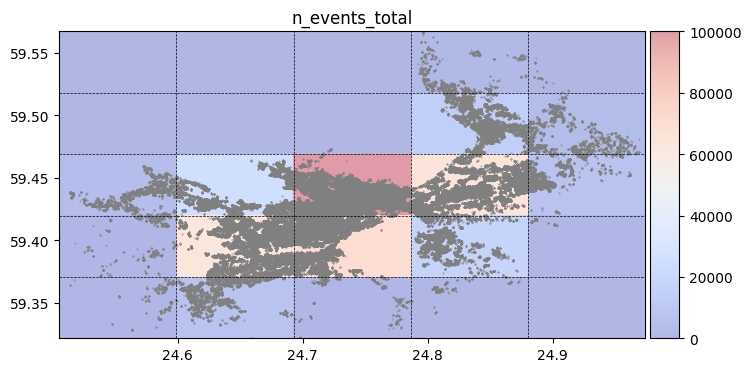

In [11]:
grid_3d = make_3d_array(gridded_data_wide, NROW, NCOL)

plot_grid(demand, grid_3d, NROW, NCOL, zmax=1e5)

Add a column with the total number of events to the wide dataset and plot. The plot shows that this concentration of events happens throughout the entire study period. For this reason, modelling will be done at several spatial levels: first, the total number of events will be modelled, and then single models for individual cells will be fitted.

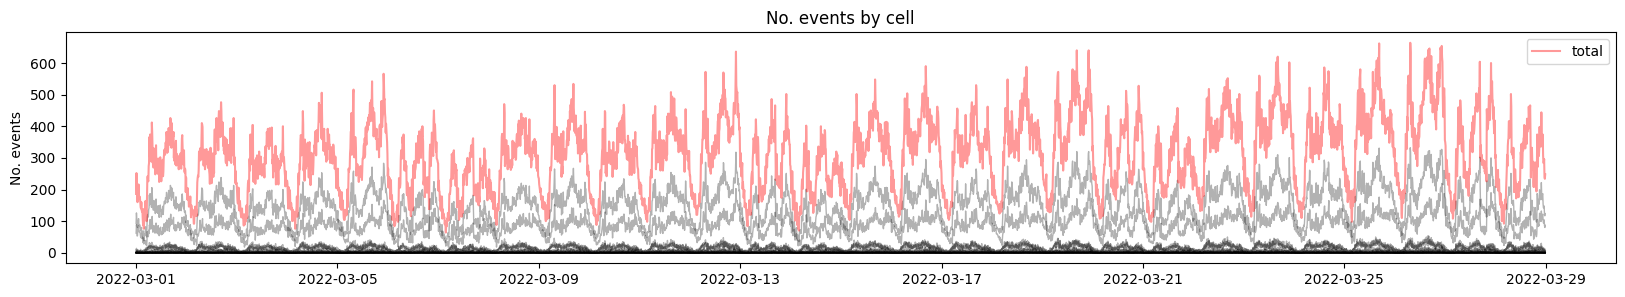

In [12]:
gridded_data_wide['n_events_total'] = gridded_data_wide.sum(axis=1)

plot_timeseries_cells(gridded_data_wide)

### **Windowing**

Data for autoregressive models must be structured in the form of a lagged dataset where features are the backshifted values of the variables ($t-1, t-2, ...$) and labels are their current values ($t$).

First, split the data into train, val and test datasets:

In [13]:
datasets = split_data(gridded_data_wide, f_train=0.6, f_val=0.2)

train: (2419, 26)
val: (806, 26)
test: (807, 26)


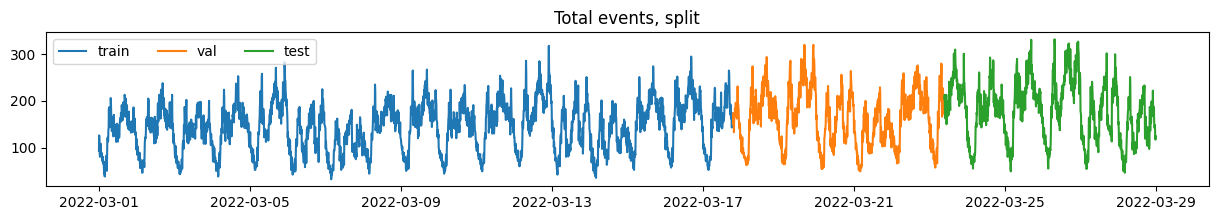

In [14]:
fig, ax = plt.subplots(figsize=(15, 2))
ax.plot(datasets['train_timestamps'], datasets['train_df_original']['n_events_total'], label='train')
ax.plot(datasets['val_timestamps'], datasets['val_df_original']['n_events_total'], label='val')
ax.plot(datasets['test_timestamps'], datasets['test_df_original']['n_events_total'], label='test')
ax.set_title('Total events, split')
ax.legend(ncol=3)
plt.show()

Then, use utility class `WindowGenerator` (based on [this guide](https://www.tensorflow.org/tutorials/structured_data/time_series)) to take care of the windowing and lagging. This class and its methods return batches of data based on `tf.keras.utils.timeseries_dataset_from_array()` to be fed into the model during training. Each returned batch is of shape `(BATCH_SIZE, N_TIMESTEPS, N_FEATURES)`.

Here's an example batch using the split datasets from above, and using only the total no. of events `n_events_total` (the same can be done for individual cells): 

In [15]:
w_dummy = WindowGenerator(
    input_width=6*12, 
    label_width=1, 
    offset=1, 
    train_df=datasets['train_df'][['n_events_total']],
    val_df=datasets['val_df'][['n_events_total']],
    test_df=datasets['test_df'][['n_events_total']],
    label_columns=['n_events_total'],
    batch_size=BATCH_SIZE)

print(f'X shape = {w_dummy.example[0].shape}')
print(f'y shape = {w_dummy.example[1].shape}')

X shape = (32, 72, 1)
y shape = (32, 1, 1)


### **Modelling `n_events_total`**

First, let's try a 1D convolutional model. Input width is the number of 10-min. timesteps from the past used as predictors and label width is 1.

In [51]:
CONV_WIDTH = 48*6
LABEL_WIDTH = 1
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)

conv = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=3, kernel_size=(CONV_WIDTH,), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(units=1),
])

w_conv = WindowGenerator(
    input_width=INPUT_WIDTH, 
    label_width=LABEL_WIDTH, 
    offset=1, 
    train_df=datasets['train_df'][['n_events_total']],
    val_df=datasets['val_df'][['n_events_total']],
    test_df=datasets['test_df'][['n_events_total']],
    batch_size=BATCH_SIZE,
    label_columns=['n_events_total'])

print(f'X shape = {w_conv.example[0].shape}')
print(f'y_pred shape = {conv(w_conv.example[0]).shape}')
print(f'y_obs shape = {w_conv.example[1].shape}')

conv(w_conv.example[0]) # build model to get number of parameters
    
print(f'Estimating {conv.count_params():,} parameters on {w_conv.train_df.shape[0]:,} datapoints')

X shape = (32, 288, 1)
y_pred shape = (32, 1, 1)
y_obs shape = (32, 1, 1)
Estimating 883 parameters on 2,419 datapoints


In [52]:
history_conv = compile_and_fit(conv, w_conv, max_epochs=MAX_EPOCHS, patience=20)

Epoch 1/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.8656 - mean_absolute_error: 0.7087 - val_loss: 0.6532 - val_mean_absolute_error: 0.6608
Epoch 2/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2419 - mean_absolute_error: 0.3892 - val_loss: 0.3193 - val_mean_absolute_error: 0.4493
Epoch 3/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2424 - mean_absolute_error: 0.3845 - val_loss: 0.2390 - val_mean_absolute_error: 0.3876
Epoch 4/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1937 - mean_absolute_error: 0.3429 - val_loss: 0.2086 - val_mean_absolute_error: 0.3592
Epoch 5/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1859 - mean_absolute_error: 0.3353 - val_loss: 0.1937 - val_mean_absolute_error: 0.3475
Epoch 6/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1752 - mean_absolute_error: 0.3281 - val_loss: 0.1863 - val_mean_absolute_error: 0.3392
Epoch 7/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1687 - mean_absolute_error: 0.3201 - val_lo

In [53]:
ypred_conv = make_ypred(conv, w_conv, datasets['train_mean']['n_events_total'], datasets['train_sd']['n_events_total'])

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


Now let's try an LSTM

In [48]:
lstm = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(units=10, return_sequences=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(units=1),
    tf.keras.layers.Reshape([1, -1])
])

w_lstm = WindowGenerator(
    input_width=12*6, 
    label_width=1, 
    offset=1, 
    train_df=datasets['train_df'][['n_events_total']],
    val_df=datasets['val_df'][['n_events_total']],
    test_df=datasets['test_df'][['n_events_total']],
    batch_size=BATCH_SIZE,
    label_columns=['n_events_total'])

lstm(w_lstm.example[0]) # build model to get number of parameters

print(f'input shape = {w_lstm.example[0].shape}')
print(f'output shape = {lstm(w_lstm.example[0]).shape}')
print(f'output data shape = {w_lstm.example[1].shape}')
print(f'Estimating {lstm.count_params():,} parameters on {w_lstm.train_df.shape[0]:,} datapoints')

input shape = (32, 72, 1)
output shape = (32, 1, 1)
output data shape = (32, 1, 1)
Estimating 531 parameters on 2,419 datapoints


In [49]:
history_lstm = compile_and_fit(lstm, w_lstm, max_epochs=MAX_EPOCHS, patience=5)

Epoch 1/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - loss: 0.5334 - mean_absolute_error: 0.5686 - val_loss: 1.3212 - val_mean_absolute_error: 0.9643
Epoch 2/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 0.1768 - mean_absolute_error: 0.3295 - val_loss: 1.2524 - val_mean_absolute_error: 0.9361
Epoch 3/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.1607 - mean_absolute_error: 0.3125 - val_loss: 1.1279 - val_mean_absolute_error: 0.8857
Epoch 4/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 0.1678 - mean_absolute_error: 0.3223 - val_loss: 0.9273 - val_mean_absolute_error: 0.7994
Epoch 5/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.1837 - mean_absolute_error: 0.3357 - val_loss: 0.7736 - val_mean_absolute_error: 0.7276
Epoch 6/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.1829 - mean_absolute_error: 0.3336 - val_loss: 0.5835 - val_mean_absolute_error: 0.6241
Epoch 7/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.1583 - mean_absolute_error: 0.3117 - v

In [54]:
ypred_lstm = make_ypred(lstm, w_lstm, datasets['train_mean']['n_events_total'], datasets['train_sd']['n_events_total'])

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


#### **Results**



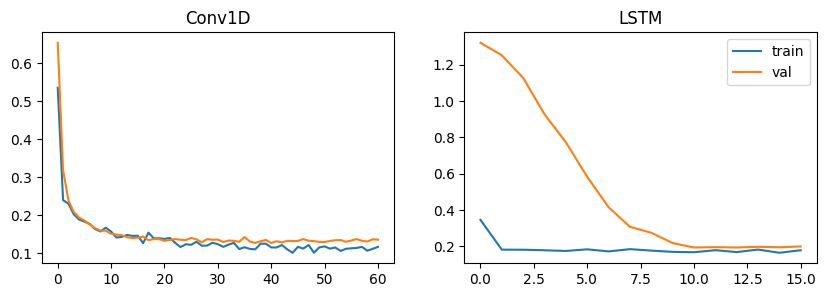

In [55]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax[0].plot(history_conv.history['loss'], label='train')
ax[0].plot(history_conv.history['val_loss'], label='val')
ax[1].plot(history_lstm.history['loss'], label='train')
ax[1].plot(history_lstm.history['val_loss'], label='val')
ax[1].legend()
ax[0].set_title('Conv1D')
ax[1].set_title('LSTM')
plt.show()

In [56]:
err_conv = ypred_conv - datasets['test_df_original']['n_events_total']
err_lstm = ypred_lstm - datasets['test_df_original']['n_events_total']

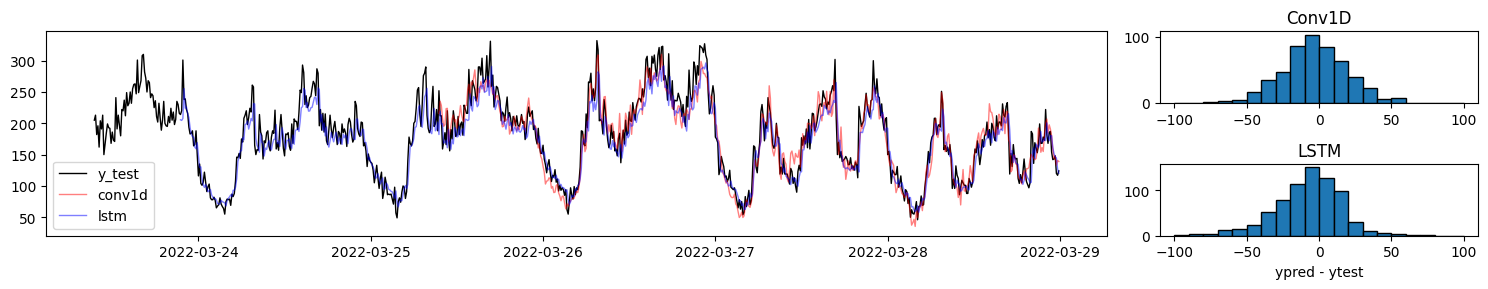

In [57]:
import matplotlib.gridspec as gridspec
import numpy as np

bins = np.arange(-100, 110, 10)
fig = plt.figure(figsize=(15, 3))
gs = gridspec.GridSpec(2, 4)

ax1 = fig.add_subplot(gs[:, :3])
ax1.plot(datasets['test_timestamps'], datasets['test_df_original']['n_events_total'], linewidth=1, color='black', label='y_test')
ax1.plot(datasets['test_timestamps'], ypred_conv, linewidth=1, color='red', alpha=0.5, label=f'conv1d')
ax1.plot(datasets['test_timestamps'], ypred_lstm, linewidth=1, color='blue', alpha=0.5, label=f'lstm')
ax1.legend()
ax2 = fig.add_subplot(gs[0, 3:])
ax2.set_title('Conv1D')
ax2.hist(err_conv, edgecolor='black', bins=bins)
ax3 = fig.add_subplot(gs[1, 3:])
ax3.set_title('LSTM')
ax3.hist(err_lstm, edgecolor='black', bins=bins)
ax3.set_xlabel('ypred - ytest')
plt.tight_layout()
plt.show()

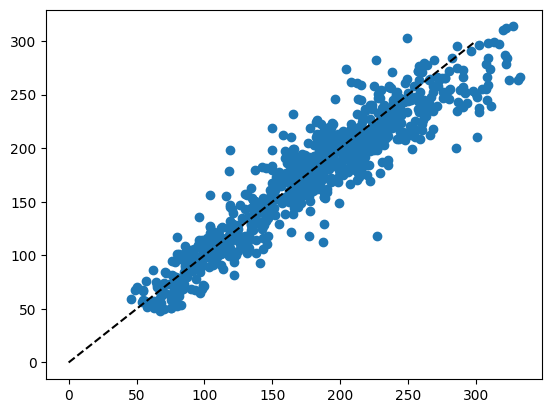

In [46]:
fig, ax = plt.subplots()
ax.scatter(datasets['test_df_original']['n_events_total'], ypred_conv)
ax.plot([0, 300], [0, 300], 'k--')
plt.show()

#### **Assessment**
